In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import paleoscripts as ps

In [3]:
files = []
for case in ['3601-3700', '3701-3800', '3801-3900', '3901-4000']:
    files.append('/home/alhafisu/nobackup/41ka1/' + case + '/srnd_41ka1.nc.gz')
ds = xr.open_mfdataset(files)

In [4]:
ds.rnd

<xarray.DataArray 'rnd' (year: 400, month: 12, latitude: 56, longitude: 64)>
dask.array<concatenate, shape=(400, 12, 56, 64), dtype=float32, chunksize=(100, 12, 56, 64), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -87.56 -84.4 -81.22 ... 81.22 84.4 87.56
  * longitude  (longitude) float32 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * month      (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * year       (year) int64 3599 3600 3601 3602 3603 ... 3995 3996 3997 3998
Attributes:
    long_name:  precipitation
    units:      mm/day

In [5]:
# pad
rnd = ps.apply_cyclic_padding(ds.rnd)
rnd

<xarray.DataArray 'rnd' (year: 400, month: 12, latitude: 56, longitude: 65)>
array([[[[0.03022315, 0.03532721, 0.03623078, ..., 0.02292636,
          0.02509523, 0.03022315],
         [0.09037368, 0.09140389, 0.08067914, ..., 0.08291027,
          0.08589455, 0.09037368],
         [0.1870396 , 0.16382933, 0.1478498 , ..., 0.14066426,
          0.20256771, 0.1870396 ],
         ...,
         [0.44263846, 0.54774755, 0.53730893, ..., 0.41861346,
          0.41293067, 0.44263846],
         [0.48239717, 0.5124625 , 0.525328  , ..., 0.36548644,
          0.409232  , 0.48239717],
         [0.18227552, 0.19736442, 0.21347384, ..., 0.14035733,
          0.16311705, 0.18227552]],

        [[0.06612531, 0.05966613, 0.05659242, ..., 0.07276697,
          0.07263444, 0.06612531],
         [0.05428521, 0.04443993, 0.03562953, ..., 0.06477664,
          0.06698617, 0.05428521],
         [0.09552325, 0.09438429, 0.07933048, ..., 0.06881171,
          0.08865912, 0.09552325],
...
         [2.048232  , 1.7815598 , 1.2256391 , ..., 1.5031724 ,
          1.9008459 , 2.048232  ],
         [1.6141438 , 1.5942712 , 1.4567631 , ..., 1.401126  ,
          1.5411932 , 1.6141438 ],
         [0.5147506 , 0.5406297 , 0.5228788 , ..., 0.43806997,
          0.49088445, 0.5147506 ]],

        [[0.07717921, 0.06860267, 0.06052073, ..., 0.09060173,
          0.08492886, 0.07717921],
         [0.14972292, 0.12012228, 0.09827476, ..., 0.18939514,
          0.17708866, 0.14972292],
         [0.20047976, 0.19177097, 0.16698763, ..., 0.18193845,
          0.18960947, 0.20047976],
         ...,
         [1.0728441 , 1.105871  , 1.0879141 , ..., 0.9039583 ,
          1.0213053 , 1.0728441 ],
         [0.98269975, 1.0256374 , 1.0600038 , ..., 0.85433775,
          0.9358549 , 0.98269975],
         [0.29598773, 0.30070886, 0.30071333, ..., 0.2553193 ,
          0.2804067 , 0.29598773]]]], dtype=float32)
Coordinates:
  * year       (year) int64 3599 3600 3601 3602 3603 ... 3995 3996 3997 3998
  * month      (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float32 -87.56 -84.4 -81.22 ... 81.22 84.4 87.56
  * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 348.8 354.4 360.0
Attributes:
    long_name:  precipitation
    units:      mm/day

In [62]:
# seasonal means across decades, after increasing the resolution
years = rnd.year.values
year_max = years[-1]
d_year = 19
rnd_season_decade_mean = {}
new_lons = np.linspace(130., 155., 101) # 0., 360., 101)
new_lats = np.linspace(-30., 30., 41) #(-87.56, 87.56, 51)
for s in ('djf', 'mam', 'jja', 'son'):
    rnd_season_decade_mean[s] = {}
    y0 = years[0]
    while y0 < year_max:
        y1 = min(y0 + d_year, year_max)
        rain = ps.extract_season(rnd.sel(year=slice(y0, y1)), s).interp(longitude=new_lons, latitude=new_lats)
        rnd_season_decade_mean[s][(y0, y1)] = rain.mean(dim=['year', 'month'])
        y0 = y1

In [63]:
# for each season, decade, we compute the max rain line
lines = {}
for s in rnd_season_decade_mean:
    lines[s] = {}
    for ys in rnd_season_decade_mean[s]:
        xy = ps.find_points_where_field_is_max(rnd_season_decade_mean[s][ys],
                                               xlim=(new_lons[0], new_lons[-1]),
                                               ylim=(new_lats[0], new_lats[-1]))
        lines[s][ys] = xy

['3599-3618', '3618-3637', '3637-3656', '3656-3675', '3675-3694', '3694-3713', '3713-3732', '3732-3751', '3751-3770', '3770-3789', '3789-3808', '3808-3827', '3827-3846', '3846-3865', '3865-3884', '3884-3903', '3903-3922', '3922-3941', '3941-3960', '3960-3979', '3979-3998']


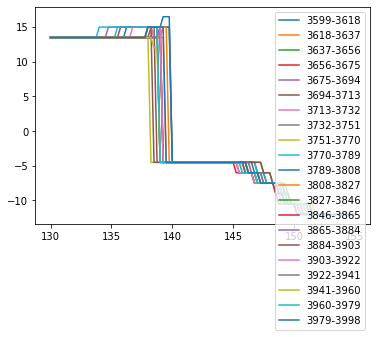

In [64]:
# plot
s = 'djf'
leg = [f'{ys[0]}-{ys[1]}' for ys in lines[s].keys()]
print(leg)
for ys in lines[s]:
    xy = lines[s][ys]
    plt.plot(xy[:, 0], xy[:, 1])
plt.legend(leg)